In [44]:
import pandas as pd
import numpy as np
import sklearn as sk


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

<h3>Data Preparation:</h3>

<h4>Definition der Dataframes:</h4>

Einlesen der Dateien als Dataframes aufgeteilt nach verschiedenen Sensoren (Accelerometer, Gyroscope, Orientation, Gravity)

In [45]:
df_walk = pd.read_json("normal_walk.json")

df_fall = pd.read_json("fall.json")

df_testFall = pd.read_json("test_fall.json")

Veranschaulichung exemplarischer Dataframes:

In [46]:
df_walk.describe()

time  seconds_elapsed             z             y  \
count  1.560600e+04     1.560600e+04  15605.000000  15605.000000   
mean   1.683269e+18    -6.919721e+02      0.051799      0.440262   
std    4.567039e+13     4.567039e+04      0.567014      1.009353   
min    1.680417e+18    -2.852898e+06     -5.566208     -5.664675   
25%    1.683270e+18     1.962529e+01     -0.221366     -0.224200   
50%    1.683270e+18     3.925919e+01      0.022858      0.793248   
75%    1.683270e+18     5.889272e+01      0.314255      1.077164   
max    1.683270e+18     7.852227e+01      4.551981      5.324697   

                  x  version  appVersion  yaw   qx   qz  roll   qw   qy  pitch  
count  15605.000000      1.0        1.00  1.0  1.0  1.0   1.0  1.0  1.0    1.0  
mean       0.023489      3.0        1.15  0.0  0.0  0.0   0.0  0.0  0.0    0.0  
std        0.893979      NaN         NaN  NaN  NaN  NaN   NaN  NaN  NaN    NaN  
min       -4.368199      3.0        1.15  0.0  0.0  0.0   0.0  0.0  0.0    0.0  
25%       -0.224045      3.0        1.15  0.0  0.0  0.0   0.0  0.0  0.0    0.0  
50%        0.062439      3.0        1.15  0.0  0.0  0.0   0.0  0.0  0.0    0.0  
75%        0.407181      3.0        1.15  0.0  0.0  0.0   0.0  0.0  0.0    0.0  
max        4.855778      3.0        1.15  0.0  0.0  0.0   0.0  0.0  0.0    0.0

Auswahl der relevanten Spalten/ Informationen aus dem Datensatz

In [47]:
df_walk.columns

Index(['sensor', 'time', 'seconds_elapsed', 'z', 'y', 'x', 'version',
       'device name', 'recording time', 'platform', 'appVersion', 'device id',
       'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy',
       'pitch'],
      dtype='object')

Umrechnung der Zeit aus Sekunden in einen Zeitstempel:

In [48]:
#preprocessing data
df_walk['time'] = pd.to_datetime(df_walk['time'])
df_fall['time'] = pd.to_datetime(df_fall['time'])
df_testFall['time'] = pd.to_datetime(df_testFall['time'])

df_walk.head()

sensor                          time  seconds_elapsed  \
0              Accelerometer 2023-04-02 06:30:19.905724160    -2.852898e+06   
1  AccelerometerUncalibrated 2023-05-05 06:58:38.144353792     1.635376e-02   
2  AccelerometerUncalibrated 2023-05-05 06:58:38.154418944     2.641895e-02   
3  AccelerometerUncalibrated 2023-05-05 06:58:38.164484096     3.648413e-02   
4  AccelerometerUncalibrated 2023-05-05 06:58:38.174548992     4.654907e-02   

          z         y         x  version device name recording time platform  \
0  0.000000  0.000000  0.000000      NaN         NaN            NaN      NaN   
1 -0.770004 -0.392059  0.095901      NaN         NaN            NaN      NaN   
2 -0.801300 -0.401917  0.068222      NaN         NaN            NaN      NaN   
3 -0.832657 -0.412109  0.057846      NaN         NaN            NaN      NaN   
4 -0.863892 -0.420822  0.063507      NaN         NaN            NaN      NaN   

   ...  device id sensors sampleRateMs yaw  qx  qz  roll  qw  qy  pitch  
0  ...        NaN     NaN          NaN NaN NaN NaN   NaN NaN NaN    NaN  
1  ...        NaN     NaN          NaN NaN NaN NaN   NaN NaN NaN    NaN  
2  ...        NaN     NaN          NaN NaN NaN NaN   NaN NaN NaN    NaN  
3  ...        NaN     NaN          NaN NaN NaN NaN   NaN NaN NaN    NaN  
4  ...        NaN     NaN          NaN NaN NaN NaN   NaN NaN NaN    NaN  

[5 rows x 21 columns]

Index als Zeitstempel definiert:

In [49]:
df_walk = df_walk.set_index('time')
df_fall = df_fall.set_index('time')
df_testFall = df_testFall.set_index('time')

Ausgabe aller Sensoren, die in Datensatz vorhanden sind:

In [50]:
df_walk['sensor'].unique()

array(['Accelerometer', 'AccelerometerUncalibrated', 'Gravity',
       'Gyroscope', 'GyroscopeUncalibrated', 'Metadata', 'Orientation'],
      dtype=object)

Aufteilung der Daten nach den zu betrachtenden Sensoren:

In [51]:
df_walk_acc = df_walk[df_walk['sensor'] == 'AccelerometerUncalibrated']
df_fall_acc = df_fall[df_fall['sensor'] == 'AccelerometerUncalibrated']
df_testFall_acc = df_testFall[df_testFall['sensor'] == 'AccelerometerUncalibrated']

df_walk_gyro = df_walk[df_walk['sensor'] == 'GyroscopeUncalibrated']
df_fall_gyro = df_fall[df_fall['sensor'] == 'GyroscopeUncalibrated']
df_testFall_gyro = df_testFall[df_testFall['sensor'] == 'GyroscopeUncalibrated']

df_walk_or = df_walk[df_walk['sensor'] == 'Orientation']
df_fall_or = df_fall[df_fall['sensor'] == 'Orientation']
df_testFall_or = df_testFall[df_testFall['sensor'] == 'Orientation']


Beschreiben des Datensatzes:

In [52]:
df_fall_or.describe()

seconds_elapsed    z    y    x  version  appVersion  yaw   qx   qz  \
count     1.000000e+00  0.0  0.0  0.0      0.0         0.0  1.0  1.0  1.0   
mean     -2.852986e+06  NaN  NaN  NaN      NaN         NaN  0.0  0.0  0.0   
std                NaN  NaN  NaN  NaN      NaN         NaN  NaN  NaN  NaN   
min      -2.852986e+06  NaN  NaN  NaN      NaN         NaN  0.0  0.0  0.0   
25%      -2.852986e+06  NaN  NaN  NaN      NaN         NaN  0.0  0.0  0.0   
50%      -2.852986e+06  NaN  NaN  NaN      NaN         NaN  0.0  0.0  0.0   
75%      -2.852986e+06  NaN  NaN  NaN      NaN         NaN  0.0  0.0  0.0   
max      -2.852986e+06  NaN  NaN  NaN      NaN         NaN  0.0  0.0  0.0   

       roll   qw   qy  pitch  
count   1.0  1.0  1.0    1.0  
mean    0.0  0.0  0.0    0.0  
std     NaN  NaN  NaN    NaN  
min     0.0  0.0  0.0    0.0  
25%     0.0  0.0  0.0    0.0  
50%     0.0  0.0  0.0    0.0  
75%     0.0  0.0  0.0    0.0  
max     0.0  0.0  0.0    0.0

Auswahl der relevanten Spalten aus den Dataframes der nach Sensordaten:

-> Hier wurden die Werte z,x,y aus den Gyro Sensoren in z_ umbenannt, um später für den join der Tabellen eindeutige Spalten zu erzeugen

In [53]:
df_walk_acc = df_walk_acc[['z','x','y']]
df_fall_acc = df_fall_acc[['z','x','y']]
df_testFall_acc = df_testFall_acc[['z','x','y']]

df_walk_gyro = df_walk_gyro[['z','x','y']]
df_fall_gyro = df_fall_gyro[['z','x','y']]
df_testFall_gyro = df_testFall_gyro[['z','x','y']]

df_walk_or = df_walk_or[['qx','qz','qw','qy']]
df_fall_or = df_fall_or[['qx','qz','qw','qy']]
df_testFall_or = df_testFall_or[['qx','qz','qw','qy']]

df_walk_gyro.rename(columns={ 'z': 'gz' , 'x': 'gx' , 'y': 'gy'}, inplace=True)
df_fall_gyro.rename(columns={ 'z': 'gz' , 'x': 'gx' , 'y': 'gy'}, inplace=True)


Plot der Dataframes zur Kontrolle und Veranschaulichung der Werte:

<Axes: xlabel='time'>

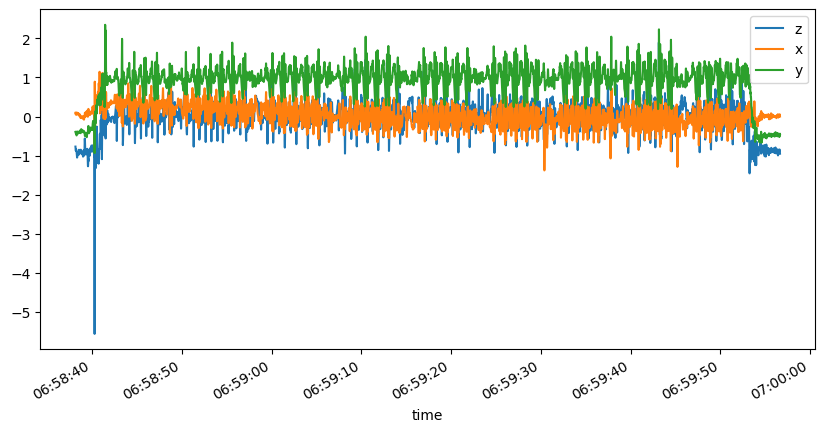

In [54]:
df_walk_acc.plot(figsize=(10,5))

<Axes: xlabel='time'>

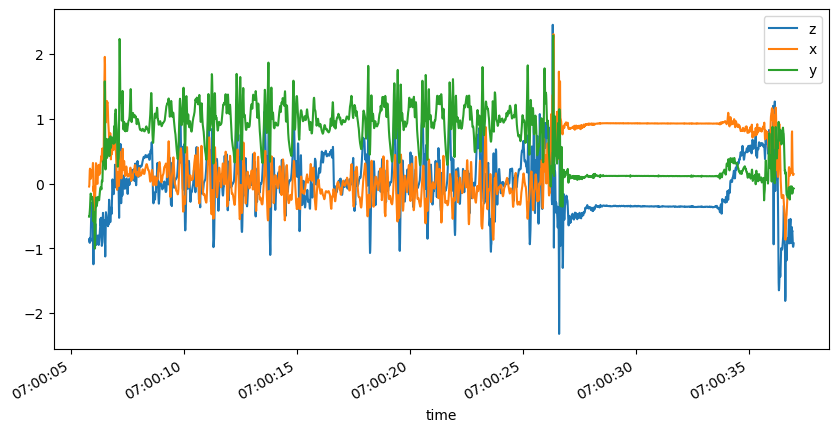

In [55]:
df_fall_acc.plot(figsize=(10,5))

<Axes: xlabel='time'>

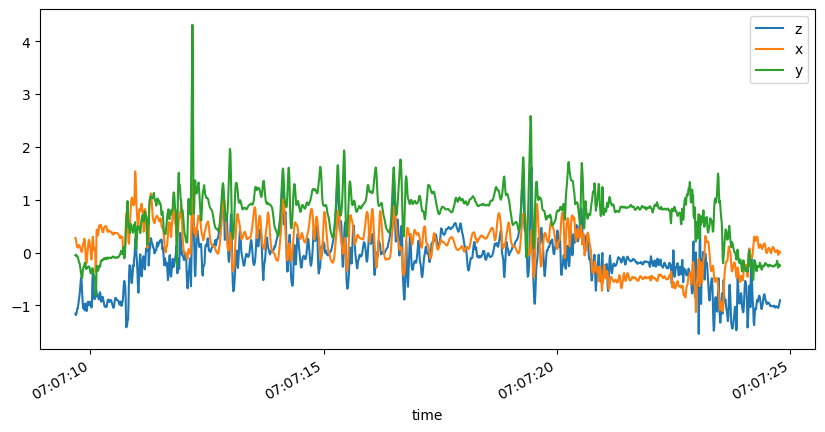

In [56]:
df_testFall_acc.plot(figsize=(10,5))

<Axes: xlabel='time'>

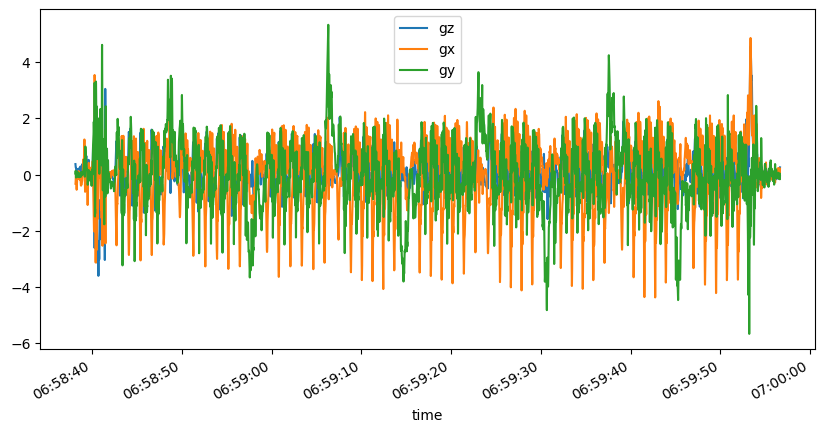

In [57]:
df_walk_gyro.plot(figsize=(10,5))

<Axes: xlabel='time'>

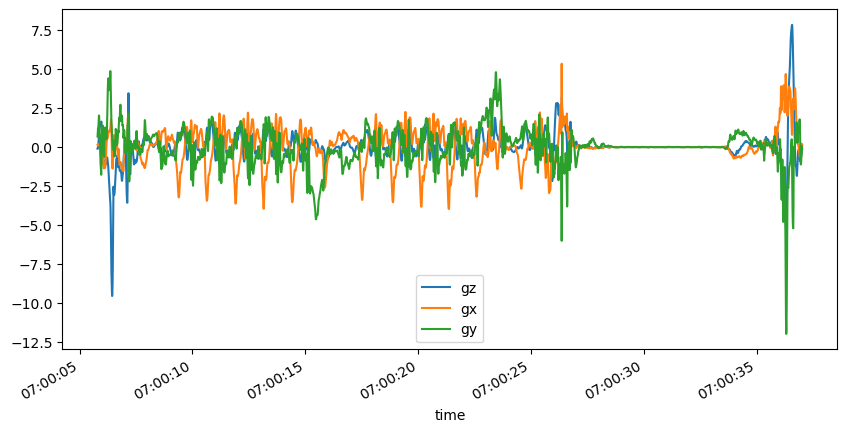

In [58]:
df_fall_gyro.plot(figsize=(10,5))

Vergabe von Labels auf der Basis des Dataframe Ursprungs (Einteilung in Walk und Fall):

-> Verbinden der verschiedenen DataFrames nach Sensoren zu einem kombinierten Dataframe

In [59]:
df_walk_acc['label'] = "walk"
df_fall_acc['label'] = "fall"

df_walk_gyro['label'] = "walk"
df_fall_gyro['label'] = "fall"

df_walk_or['label'] = "walk"
df_fall_or['label'] = "fall"

df_testFall_acc['label'] = "fall"
df_testFall_gyro['label'] = "fall"
df_testFall_or['label'] = "fall"

df_combined_walk = pd.merge(df_walk_acc, df_walk_gyro, on='time')
df_combined_fall = pd.merge(df_fall_acc, df_fall_gyro, on='time')

Check der kombinierten DataFrames:

In [60]:
df_combined_walk.describe()

z            x            y           gz           gx  \
count  7801.000000  7801.000000  7801.000000  7801.000000  7801.000000   
mean      0.007949     0.011915     0.888821     0.095670     0.035072   
std       0.414037     0.285507     0.442417     0.684032     1.231675   
min      -5.566208    -1.379913    -0.936035    -3.600134    -4.368199   
25%      -0.146286    -0.183304     0.815964    -0.303015    -0.431574   
50%       0.014450     0.001541     0.968018     0.042925     0.237751   
75%       0.232178     0.202698     1.135757     0.459139     0.857483   
max       1.896194     1.145966     2.349152     4.551981     4.855778   

                gy  
count  7801.000000  
mean     -0.008127  
std       1.199997  
min      -5.664675  
25%      -0.645348  
50%      -0.074779  
75%       0.722251  
max       5.324697

In [61]:
df_combined_fall.head(-5)

z         x         y label_x        gz  \
time                                                                            
2023-05-05 07:00:05.796345344 -0.858704 -0.043808 -0.510193    fall -0.107170   
2023-05-05 07:00:05.806409472 -0.895935 -0.021576 -0.511230    fall -0.108921   
2023-05-05 07:00:05.816474368 -0.902679  0.091705 -0.473236    fall  0.010160   
2023-05-05 07:00:05.826539264 -0.914108  0.206802 -0.422516    fall  0.160927   
2023-05-05 07:00:05.836603392 -0.835724  0.232285 -0.367661    fall  0.297366   
...                                 ...       ...       ...     ...       ...   
2023-05-05 07:00:36.906024448 -0.727997  0.249161 -0.148407    fall -0.912278   
2023-05-05 07:00:36.916088320 -0.670898  0.756439 -0.043152    fall -0.565928   
2023-05-05 07:00:36.926153472 -0.746384  0.807922 -0.078064    fall -0.435041   
2023-05-05 07:00:36.936217344 -0.725372  0.455109 -0.151993    fall -0.450674   
2023-05-05 07:00:36.946282496 -0.816238  0.254303 -0.138718    fall -0.548578   

                                     gx        gy label_y  
time                                                       
2023-05-05 07:00:05.796345344  0.143945  0.668648    fall  
2023-05-05 07:00:05.806409472  0.115393  0.904805    fall  
2023-05-05 07:00:05.816474368  0.078004  1.210142    fall  
2023-05-05 07:00:05.826539264  0.132769  1.255230    fall  
2023-05-05 07:00:05.836603392  0.192376  1.384964    fall  
...                                 ...       ...     ...  
2023-05-05 07:00:36.906024448 -0.531905  0.746090    fall  
2023-05-05 07:00:36.916088320 -0.367368 -0.153228    fall  
2023-05-05 07:00:36.926153472 -0.237608 -0.687723    fall  
2023-05-05 07:00:36.936217344 -0.128747 -1.116218    fall  
2023-05-05 07:00:36.946282496 -0.012386 -1.082011    fall  

[3095 rows x 8 columns]

Bestimmung der Länge der Datensätze:

In [62]:
df_help = df_combined_walk.reset_index()
print(df_help.iloc[-1,0] - df_help.iloc[0,0])

0 days 00:01:18.505917184


Ausschluss der Spalte "label_x" da redundant: 

In [63]:
df_combined_walk.drop('label_x',axis=1, inplace=True)
df_combined_fall.drop('label_x',axis=1, inplace=True)

Überprüfen der Vollständigkeit des Datensatzes:

In [64]:
laenge = len(df_walk_acc) + len(df_walk_gyro)
print("Doppelte Zeilen in Dataframes, ohne join auf Time:", laenge)
print("Einfache Anzahl an Zeilen, bei richtigem Merge:",len(df_combined_walk))
print("Länge des Merges:", len(df_combined_walk))

Doppelte Zeilen in Dataframes, ohne join auf Time: 15602
Einfache Anzahl an Zeilen, bei richtigem Merge: 7801
Länge des Merges: 7801


Aufteilen der DF's in einzelne Abschnitte mit den Abständen 100 Datenpunkte:
- ToDo: Anpassen der Länge von Sequenzen und deren Auswirkung auf die Modellgüte/ Accuracy

In [65]:
df_combined_walk['id'] = 0
df_combined_fall['id'] = 0

id = 1

var1 = 100
var2 = 100

for i in range(0, len(df_combined_walk)):
    df_combined_walk.iloc[i,7] = id
    

    if i >= var1: 
        var1 = var1 + 100
        id+=1
    
for i in range(0, len(df_combined_fall)):
    
    df_combined_fall.iloc[i,7] = id

    if i >= var2: 
        var2 = var2 + 100
        id+=1  

In [66]:
df_combined_walk

z         x         y        gz  \
time                                                                    
2023-05-05 06:58:38.144353792 -0.770004  0.095901 -0.392059  0.372627   
2023-05-05 06:58:38.154418944 -0.801300  0.068222 -0.401917  0.323937   
2023-05-05 06:58:38.164484096 -0.832657  0.057846 -0.412109  0.290018   
2023-05-05 06:58:38.174548992 -0.863892  0.063507 -0.420822  0.261301   
2023-05-05 06:58:38.184613888 -0.873398  0.073227 -0.429611  0.247048   
...                                 ...       ...       ...       ...   
2023-05-05 06:59:56.610012928 -0.848389  0.046661 -0.506805  0.156614   
2023-05-05 06:59:56.620076800 -0.861221  0.055542 -0.488983  0.198738   
2023-05-05 06:59:56.630141952 -0.900436  0.041672 -0.465683  0.213338   
2023-05-05 06:59:56.640205824 -0.947311  0.015182 -0.440048  0.233150   
2023-05-05 06:59:56.650270976 -0.951538  0.000778 -0.452438  0.256048   

                                     gx        gy label_y  id  
time                                                           
2023-05-05 06:58:38.144353792 -0.326558  0.034030    walk   1  
2023-05-05 06:58:38.154418944 -0.311438  0.098708    walk   1  
2023-05-05 06:58:38.164484096 -0.266175  0.137501    walk   1  
2023-05-05 06:58:38.174548992 -0.182474  0.126971    walk   1  
2023-05-05 06:58:38.184613888 -0.094612  0.046177    walk   1  
...                                 ...       ...     ...  ..  
2023-05-05 06:59:56.610012928 -0.159282  0.041310    walk  78  
2023-05-05 06:59:56.620076800 -0.107488 -0.042373    walk  78  
2023-05-05 06:59:56.630141952  0.035620 -0.167855    walk  78  
2023-05-05 06:59:56.640205824  0.154310 -0.159228    walk  78  
2023-05-05 06:59:56.650270976  0.211679 -0.060103    walk  78  

[7801 rows x 8 columns]

In [67]:
df_combined_fall

z         x         y        gz  \
time                                                                    
2023-05-05 07:00:05.796345344 -0.858704 -0.043808 -0.510193 -0.107170   
2023-05-05 07:00:05.806409472 -0.895935 -0.021576 -0.511230 -0.108921   
2023-05-05 07:00:05.816474368 -0.902679  0.091705 -0.473236  0.010160   
2023-05-05 07:00:05.826539264 -0.914108  0.206802 -0.422516  0.160927   
2023-05-05 07:00:05.836603392 -0.835724  0.232285 -0.367661  0.297366   
...                                 ...       ...       ...       ...   
2023-05-05 07:00:36.956347136 -0.940689  0.155502 -0.105499 -0.561477   
2023-05-05 07:00:36.966411264 -0.969910  0.134750 -0.089905 -0.470264   
2023-05-05 07:00:36.976476416 -0.975662  0.134018 -0.077606 -0.320177   
2023-05-05 07:00:36.986540288 -0.956848  0.143326 -0.068573 -0.191300   
2023-05-05 07:00:36.996605440 -0.922028  0.148407 -0.074005 -0.137353   

                                     gx        gy label_y   id  
time                                                            
2023-05-05 07:00:05.796345344  0.143945  0.668648    fall   79  
2023-05-05 07:00:05.806409472  0.115393  0.904805    fall   79  
2023-05-05 07:00:05.816474368  0.078004  1.210142    fall   79  
2023-05-05 07:00:05.826539264  0.132769  1.255230    fall   79  
2023-05-05 07:00:05.836603392  0.192376  1.384964    fall   79  
...                                 ...       ...     ...  ...  
2023-05-05 07:00:36.956347136  0.103614 -0.864238    fall  109  
2023-05-05 07:00:36.966411264  0.181803 -0.671422    fall  109  
2023-05-05 07:00:36.976476416  0.209357 -0.403196    fall  109  
2023-05-05 07:00:36.986540288  0.201019 -0.126644    fall  109  
2023-05-05 07:00:36.996605440  0.165329  0.047995    fall  109  

[3100 rows x 8 columns]

Konkatenieren der verschiedenen Dataframes zu einem gemeinsamen DF:

In [68]:
df_combined = pd.concat([df_combined_walk, df_combined_fall])

In [69]:
df_combined

z         x         y        gz  \
time                                                                    
2023-05-05 06:58:38.144353792 -0.770004  0.095901 -0.392059  0.372627   
2023-05-05 06:58:38.154418944 -0.801300  0.068222 -0.401917  0.323937   
2023-05-05 06:58:38.164484096 -0.832657  0.057846 -0.412109  0.290018   
2023-05-05 06:58:38.174548992 -0.863892  0.063507 -0.420822  0.261301   
2023-05-05 06:58:38.184613888 -0.873398  0.073227 -0.429611  0.247048   
...                                 ...       ...       ...       ...   
2023-05-05 07:00:36.956347136 -0.940689  0.155502 -0.105499 -0.561477   
2023-05-05 07:00:36.966411264 -0.969910  0.134750 -0.089905 -0.470264   
2023-05-05 07:00:36.976476416 -0.975662  0.134018 -0.077606 -0.320177   
2023-05-05 07:00:36.986540288 -0.956848  0.143326 -0.068573 -0.191300   
2023-05-05 07:00:36.996605440 -0.922028  0.148407 -0.074005 -0.137353   

                                     gx        gy label_y   id  
time                                                            
2023-05-05 06:58:38.144353792 -0.326558  0.034030    walk    1  
2023-05-05 06:58:38.154418944 -0.311438  0.098708    walk    1  
2023-05-05 06:58:38.164484096 -0.266175  0.137501    walk    1  
2023-05-05 06:58:38.174548992 -0.182474  0.126971    walk    1  
2023-05-05 06:58:38.184613888 -0.094612  0.046177    walk    1  
...                                 ...       ...     ...  ...  
2023-05-05 07:00:36.956347136  0.103614 -0.864238    fall  109  
2023-05-05 07:00:36.966411264  0.181803 -0.671422    fall  109  
2023-05-05 07:00:36.976476416  0.209357 -0.403196    fall  109  
2023-05-05 07:00:36.986540288  0.201019 -0.126644    fall  109  
2023-05-05 07:00:36.996605440  0.165329  0.047995    fall  109  

[10901 rows x 8 columns]

Check auf Nullwerte:

In [70]:
df_combined.isnull().sum()

z          0
x          0
y          0
gz         0
gx         0
gy         0
label_y    0
id         0
dtype: int64

In [71]:
df_combined.reset_index(inplace=True)
df_combined.head()

time         z         x         y        gz  \
0 2023-05-05 06:58:38.144353792 -0.770004  0.095901 -0.392059  0.372627   
1 2023-05-05 06:58:38.154418944 -0.801300  0.068222 -0.401917  0.323937   
2 2023-05-05 06:58:38.164484096 -0.832657  0.057846 -0.412109  0.290018   
3 2023-05-05 06:58:38.174548992 -0.863892  0.063507 -0.420822  0.261301   
4 2023-05-05 06:58:38.184613888 -0.873398  0.073227 -0.429611  0.247048   

         gx        gy label_y  id  
0 -0.326558  0.034030    walk   1  
1 -0.311438  0.098708    walk   1  
2 -0.266175  0.137501    walk   1  
3 -0.182474  0.126971    walk   1  
4 -0.094612  0.046177    walk   1

In [72]:
df_combined.replace(['walk'],0,inplace=True)
df_combined.replace(['fall'],1,inplace=True)
df_combined.head()

time         z         x         y        gz  \
0 2023-05-05 06:58:38.144353792 -0.770004  0.095901 -0.392059  0.372627   
1 2023-05-05 06:58:38.154418944 -0.801300  0.068222 -0.401917  0.323937   
2 2023-05-05 06:58:38.164484096 -0.832657  0.057846 -0.412109  0.290018   
3 2023-05-05 06:58:38.174548992 -0.863892  0.063507 -0.420822  0.261301   
4 2023-05-05 06:58:38.184613888 -0.873398  0.073227 -0.429611  0.247048   

         gx        gy  label_y  id  
0 -0.326558  0.034030        0   1  
1 -0.311438  0.098708        0   1  
2 -0.266175  0.137501        0   1  
3 -0.182474  0.126971        0   1  
4 -0.094612  0.046177        0   1

Berechnen der extracted_features mit tsfresh: 

from tsfresh import extract_features
extracted_features = extract_features(df_combined, column_id="id",column_sort='time')

Ausgeben der errechneten Features mittels TsFresh:

In [73]:
extracted_features

z__variance_larger_than_standard_deviation  z__has_duplicate_max  \
1                                           0.0                   0.0   
2                                           0.0                   0.0   
3                                           0.0                   0.0   
4                                           0.0                   0.0   
5                                           0.0                   0.0   
..                                          ...                   ...   
105                                         0.0                   0.0   
106                                         0.0                   0.0   
107                                         0.0                   0.0   
108                                         0.0                   0.0   
109                                         0.0                   0.0   

     z__has_duplicate_min  z__has_duplicate  z__sum_values  z__abs_energy  \
1                     0.0               0.0     -93.162186      86.228242   
2                     0.0               0.0     -89.148010      81.172102   
3                     0.0               0.0     -73.498352      91.606258   
4                     0.0               0.0      -7.005432       3.531542   
5                     0.0               0.0       8.843323       5.324660   
..                    ...               ...            ...            ...   
105                   0.0               1.0     -35.633606      12.698285   
106                   0.0               1.0     -34.770935      12.280162   
107                   0.0               0.0      23.019043      11.751855   
108                   0.0               1.0      58.027222      34.479675   
109                   0.0               0.0     -54.708389      80.189605   

     z__mean_abs_change  z__mean_change  z__mean_second_derivative_central  \
1              0.018815       -0.001584                           0.000305   
2              0.031519       -0.000580                          -0.000823   
3              0.226267        0.009452                          -0.000332   
4              0.079094       -0.001733                           0.000146   
5              0.036011        0.006891                           0.000309   
..                  ...             ...                                ...   
105            0.001786       -0.000071                          -0.000018   
106            0.009576        0.001070                           0.000181   
107            0.024704        0.007959                           0.000034   
108            0.040497       -0.001848                          -0.000365   
109            0.178128       -0.014033                           0.000157   

     z__median  ...  label_y__fourier_entropy__bins_5  \
1    -0.928360  ...                               0.0   
2    -0.877502  ...                               0.0   
3    -0.773949  ...                               0.0   
4    -0.064857  ...                               0.0   
5     0.029686  ...                               0.0   
..         ...  ...                               ...   
105  -0.356194  ...                               0.0   
106  -0.357529  ...                               0.0   
107   0.289558  ...                               0.0   
108   0.586349  ...                               0.0   
109  -0.811523  ...                               0.0   

     label_y__fourier_entropy__bins_10  label_y__fourier_entropy__bins_100  \
1                                  0.0                                 0.0   
2                                  0.0                                 0.0   
3                                  0.0                                 0.0   
4                                  0.0                                 0.0   
5                                  0.0                                 0.0   
..                                 ...                                 ...   
105                                

In [74]:
labels= df_combined[['id','label_y']]
labels= labels.drop_duplicates()
labels= labels.set_index('id')
y= labels.iloc[:,0]
print(y)


id
1      0
2      0
3      0
4      0
5      0
      ..
105    1
106    1
107    1
108    1
109    1
Name: label_y, Length: 109, dtype: int64


ACHTUNG: select_features vs. extract_relevant_features Unterschied ermitteln, Recherche

Features_filtered wird nicht weiter benutzt

from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
#test
impute(extracted_features)
features_filtered = select_features(extracted_features,y)

In [75]:
from tsfresh import extract_relevant_features

features_filtered_direct = extract_relevant_features(df_combined, y,
                                                     column_id='id', column_sort='time')

Feature Extraction: 100%|██████████| 10/10 [00:53<00:00,  5.34s/it]


features_filtered.columns

In [77]:
features_filtered_direct.columns

Index(['label_y__count_below__t_0',
       'label_y__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)',
       ...
       'label_y__range_count__max_1__min_-1', 'label_y__value_count__value_0',
       'z__permutation_entropy__dimension_7__tau_1',
       'gz__ratio_beyond_r_sigma__r_3',
       'z__permutation_entropy__dimension_6__tau_1',
       'z__permutation_entropy__dimension_5__tau_1',
       'z__permuta

In [78]:
X_train, X_test, y_train, y_test = train_test_split(features_filtered_direct, y, test_size=0.30, random_state=101)

In [79]:
y_test

id
86     1
26     0
103    1
33     0
109    1
17     0
2      0
51     0
48     0
49     0
32     0
56     0
14     0
99     1
62     0
85     1
46     0
22     0
72     0
7      0
91     1
68     0
95     1
15     0
55     0
83     1
90     1
54     0
4      0
59     0
47     0
44     0
58     0
Name: label_y, dtype: int64

In [80]:
#KNN
knn = KNeighborsClassifier(n_neighbors=3,weights='distance')
knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)

In [81]:
#Test via Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[24  0]
 [ 0  9]]


In [84]:
from sklearn.ensemble import RandomForestClassifier

In [87]:
#randomforest
rf= RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

#Test via Konfusionsmatrix
dm = confusion_matrix(y_test, y_pred)
print(dm)

[[24  0]
 [ 0  9]]
